In [1]:
import pandas as pd
import ast
from sklearn.preprocessing import MultiLabelBinarizer

# Load Data

In [2]:
ndc = pd.read_csv('data/ndc.csv')

In [3]:
label = pd.read_csv('data/label.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

## Join the Files

In [4]:
df = ndc.merge(
    label,
    left_on='spl_id',
    right_on='id',
    how='left'
)

In [5]:
# delete the dataframes to save memory
del ndc 
del label

## Remove unfinished products because the FDA only reviews finished products. 

In [6]:
df = df.query('finished == True')

In [7]:
df.columns

Index(['product_id', 'product_ndc', 'spl_id', 'application_number',
       'dea_schedule', 'dosage_form', 'finished', 'marketing_category',
       'marketing_start_date', 'marketing_end_date', 'openfda.pharm_class_cs',
       'openfda.pharm_class_epc', 'openfda.pharm_class_pe',
       'openfda.pharm_class_moa', 'pharm_class', 'product_type', 'route', 'id',
       'set_id', 'version', 'effective_time', 'drug_interactions'],
      dtype='object')

## Select Columns 

Exclude IDs and other columns that won't be used as features due to bias detected during the exploration phase. 

In [8]:
cols_to_keep = [
    'application_number',
    'dea_schedule',
    'dosage_form',
    'marketing_start_date',
    'openfda.pharm_class_cs',
    'openfda.pharm_class_epc',
    'openfda.pharm_class_pe',
    'openfda.pharm_class_moa',
    'product_type',
    'route',
    'drug_interactions'
]

In [9]:
df = df[cols_to_keep]

## Derive Target

Derive target variable from application_number. All products with an application number have been approved. 

In [10]:
df['approved'] = df['application_number'].apply(lambda x: 1 if pd.notnull(x) else 0)

In [11]:
df.drop(columns=['application_number'], inplace=True)

## Replace Nulls 

In [12]:
df.isna().sum() / len(df)

dea_schedule               0.955558
dosage_form                0.000000
marketing_start_date       0.000000
openfda.pharm_class_cs     0.852796
openfda.pharm_class_epc    0.730471
openfda.pharm_class_pe     0.879947
openfda.pharm_class_moa    0.871066
product_type               0.000000
route                      0.018502
drug_interactions          0.648037
approved                   0.000000
dtype: float64

All columns with nulls are categorical, so let's replace their nulls with a single category. 

In [13]:
for col in df.columns[df.isna().sum() > 0]:
    df[col].fillna('N/A', inplace=True)

In [14]:
df.isna().sum()

dea_schedule               0
dosage_form                0
marketing_start_date       0
openfda.pharm_class_cs     0
openfda.pharm_class_epc    0
openfda.pharm_class_pe     0
openfda.pharm_class_moa    0
product_type               0
route                      0
drug_interactions          0
approved                   0
dtype: int64

# Feature Creation

## Marketing Start Month

Derive month from marketing_start_date. 

In [15]:
df['marketing_start_date'] = pd.to_datetime(df['marketing_start_date'], format='%Y%m%d')

In [16]:
df['marketing_start_month'] = df['marketing_start_date'].dt.month

In [17]:
df.drop(columns=['marketing_start_date'], inplace=True)

## Mentions Drug Interactions

In [18]:
df['mentions_drug_interactions'] = df['drug_interactions'].apply(lambda x: 0 if x == 'N/A' else 1)

In [19]:
df.drop(columns=['drug_interactions'], inplace=True)

# Feature Transformation

## Lists to Binary Columns

Some of the columns contain lists of categories. We need to convert these into binary columns for each category. This is like one-hot-encoding, but with lists of values instead of a single value. However, these fields are currently stored as strings, so we first need to literally evaluate them as lists. 

In [20]:
cols_with_lists = [
    'route',
    'openfda.pharm_class_cs',
    'openfda.pharm_class_epc',
    'openfda.pharm_class_pe',
    'openfda.pharm_class_moa'
]

In [21]:
for col in cols_with_lists:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if x != 'N/A' else x.split())

Now let's create a function to binarize each column that contains lists as values.

In [22]:
def binarize_list_column(df, colname):
    mlb = MultiLabelBinarizer()
    mlb.fit(df[colname])
    class_names = [colname + '_' + c for c in mlb.classes_]
    return pd.DataFrame(mlb.transform(df[colname]), columns=class_names) 

Apply the function to each column and horizontally concatenate the results to the input dataframe. 

In [23]:
for col in cols_with_lists:
    pd.concat([df, binarize_list_column(df, col)], axis=1)

Now we can drop the original untransformed columns. 

In [24]:
df.drop(columns=cols_with_lists, inplace=True)

## One-Hot Encoding

In [25]:
categorical_cols = [
    'dea_schedule',
    'product_type',
    'dosage_form',
    'marketing_start_month'
]

In [26]:
df = pd.get_dummies(
    df,
    columns=categorical_cols,
    drop_first=True
)

# Feature Selection

In [27]:
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt

In [28]:
y = df['approved'].values
X = df.drop(columns=['approved']).values

In [29]:
mutual_info = mutual_info_classif(X, y)

In [30]:
feature_importance = pd.DataFrame(mutual_info, index=df.columns.drop('approved'), columns=['importance'])

In [31]:
feature_importance.sort_values('importance', ascending=False, inplace=True)

In [32]:
feature_importance_non_zero = feature_importance[feature_importance['importance'] > 0]

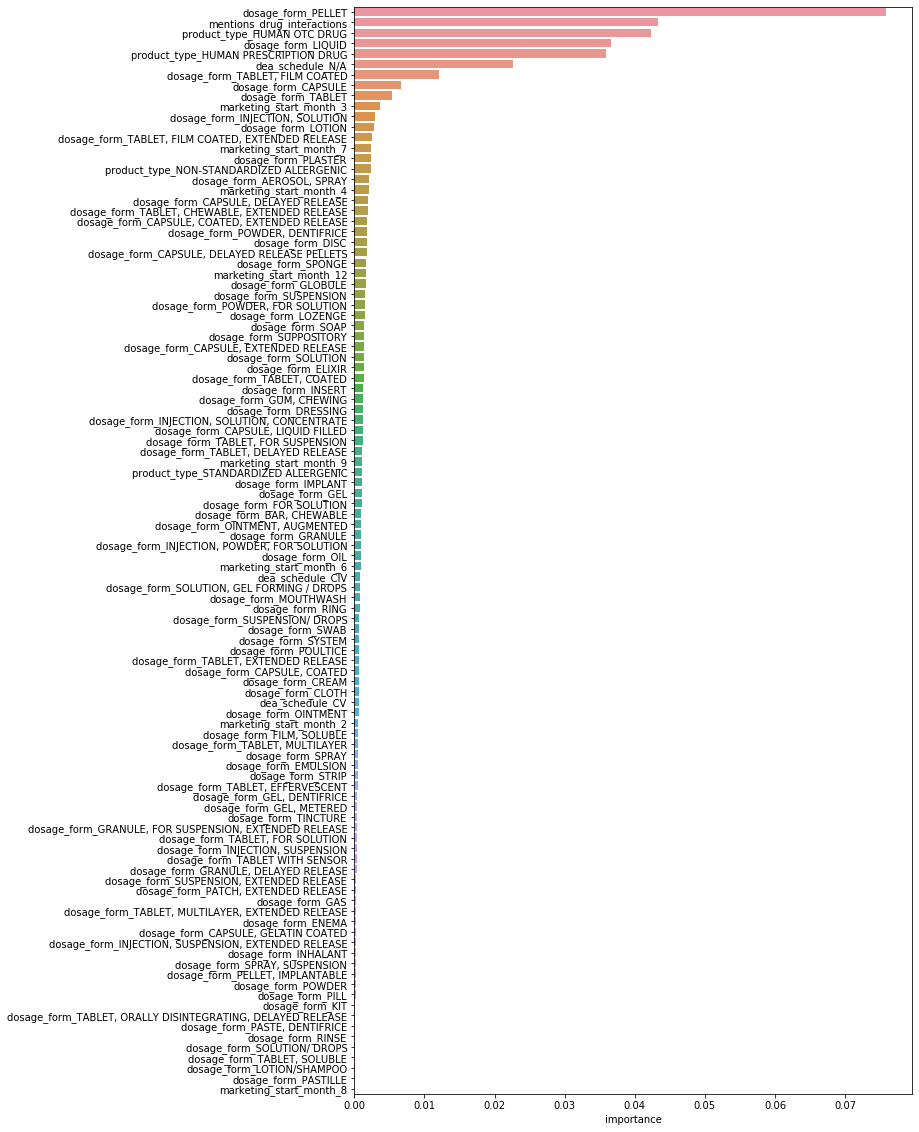

In [33]:
fig, ax = plt.subplots(figsize=(10, 20))
sns.barplot(
    data=feature_importance_non_zero,
    x='importance',
    y=feature_importance_non_zero.index
)
plt.show()

In [34]:
chosen_features = feature_importance.index[:11]

In [35]:
print('The most important features based on their mutual information with approved are:')
for f in chosen_features:
    print('- {}'.format(f))

The most important features based on their mutual information with approved are:
- dosage_form_PELLET
- mentions_drug_interactions
- product_type_HUMAN OTC DRUG
- dosage_form_LIQUID
- product_type_HUMAN PRESCRIPTION DRUG
- dea_schedule_N/A
- dosage_form_TABLET, FILM COATED
- dosage_form_CAPSULE
- dosage_form_TABLET
- marketing_start_month_3
- dosage_form_INJECTION, SOLUTION


In [36]:
df_final = df[chosen_features]

In [37]:
df_final = pd.concat([df['approved'], df_final], axis=1)

# Balance Dataset

In [38]:
df_final['approved'].value_counts(normalize=True)

1    0.874362
0    0.125638
Name: approved, dtype: float64

The target class is imbalanced: 87% approved vs. 13% unapproved. Let's balance it by undersampling the majority class. 

In [39]:
df_grouped = df.groupby('approved')

In [40]:
df_balanced = df_grouped.apply(
    lambda x: x.sample(df_grouped.size().min(), random_state=0) \
    .reset_index(drop=True)
)

In [41]:
df_balanced['approved'].value_counts(normalize=True)

1    0.5
0    0.5
Name: approved, dtype: float64

# Split Dataset into Train, Validation, and Test Sets

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
# Split data into 80% train and 10% holdout 
df_train, df_holdout = train_test_split(
    df_balanced,
    test_size=0.2,
    stratify=df_balanced['approved'],
    random_state=0
)

In [44]:
# Split holdout data into 50% validation and 50% test
df_validation, df_test = train_test_split(
    df_holdout,
    test_size=0.5,
    stratify=df_holdout['approved'],
    random_state=0
)

# Upload Datasets to S3

In [45]:
import sagemaker

In [46]:
session = sagemaker.Session()

In [47]:
session.upload_string_as_file_body(
    body=df_train.to_csv(index=False, header=False),
    bucket=session.default_bucket(),
    key='data/train/train/data.csv'
)

's3://sagemaker-us-east-1-954599102482/data/train/train/data.csv'

In [48]:
session.upload_string_as_file_body(
    body=df_validation.to_csv(index=False, header=False),
    bucket=session.default_bucket(),
    key='data/train/validation/data.csv'
)

's3://sagemaker-us-east-1-954599102482/data/train/validation/data.csv'

In [49]:
session.upload_string_as_file_body(
    body=df_test.to_csv(index=False, header=False),
    bucket=session.default_bucket(),
    key='data/test/data.csv'
)

's3://sagemaker-us-east-1-954599102482/data/test/data.csv'